# 🧾 Notebook Summary: Fracture & Geom Rasterization

This notebook combines two workflows:
- **Loading and visualizing 2D discrete fracture network (DFN) data**.
- **Overlaying the fracture network (`kdfn`) onto a loaded geometry (`geom`)**.
- **Rasterizing the combined plot into a NumPy matrix**, where:
  - `1` indicates geometry.
  - `0` indicates fractures (with adjustable thickness).

---

## ✅ Key Steps
1. **Load geom data** from `geom` (a NumPy array of shape `(1080, 1920)`).
2. **Generate or load fractures** into `final_fractures`, each with:
   - `x, y`: center
   - `theta`: orientation (in radians)
   - `h`: half-length
   - `active`: Boolean flag (optional)
3. **Overlay fractures on top of geom** using:
   - Pure `matplotlib` plotting (no GeoPandas)
   - Line segments centered at fracture coordinates
4. **Convert plot to a NumPy matrix**:
   - Geom is rasterized as `1`s.
   - Fractures are drawn over it as `0`s using a disk-drawing function to simulate line thickness.
   - Final matrix matches shape of `geom`.

---

## 📦 Dependencies

This notebook requires the following Python packages:

```python
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from shapely.geometry import LineString, Point  
import scipy 
from scipy.io import savemat
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import os


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from shapely.geometry import LineString, Point  
import scipy 
from scipy.io import savemat
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import os

In [2]:
# Define your .mat file path
mat_file_path = 'binarymap.mat'  # Replace with the actual file path

# Check file existence
if not os.path.exists(mat_file_path):
    raise FileNotFoundError(f"The file {mat_file_path} does not exist.")

In [3]:

# Attempt loading using scipy.io (works for MATLAB v7.2 and below)
try:
    mat_data = scipy.io.loadmat(mat_file_path)
    print("Loaded using scipy.io.loadmat:")
    for key in mat_data:
        if not key.startswith('__'):
            print(f"{key}: {type(mat_data[key])}, shape: {getattr(mat_data[key], 'shape', 'scalar')}")
except NotImplementedError:
    print("scipy.io.loadmat failed (likely a v7.3+ file). Trying h5py...")

    # Try loading using h5py (for MATLAB v7.3+ files)
    with h5py.File(mat_file_path, 'r') as f:
        print("Loaded using h5py:")
        def print_structure(name, obj):
            print(f"{name}: {type(obj)}")
        f.visititems(print_structure)

Loaded using scipy.io.loadmat:
geom: <class 'numpy.ndarray'>, shape: (1080, 1920)


In [4]:
geom = mat_data['geom'] 

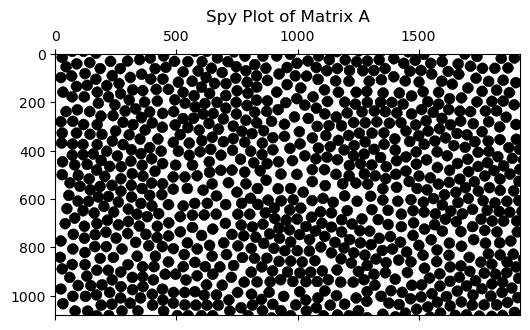

In [5]:
# Make a spy plot
plt.figure(figsize=(6, 6))
plt.spy(geom, markersize=0.1, color = 'k')
plt.title("Spy Plot of Matrix A")
plt.show()

# 2D DFN Generation via Nucleation–Growth–Arrest (Mode A)

This notebook implements a 2D version of the **nucleation–growth–arrest** DFN model described in Davy et al. (2013), using **Mode A** arrest (stop at first intersection with a strictly larger fracture). Fractures are represented as line segments in a square domain `[0, L] × [0, L]`.  

**Key steps:**
1. **Nucleation**: Uniformly random in space and orientation, at a constant rate `n_rate`.  
2. **Growth**: Subcritical power-law \(d\ell/dt = C \ell^a\) (Charles’ law).  
3. **Arrest (Mode A)**: A growing fracture stops at its first intersection with any strictly larger fracture.  

Throughout, we use the [Shapely](https://pypi.org/project/Shapely/) library for 2D geometry (segment intersection, etc.).  

Below, adjust the model parameters as desired and run each cell in sequence.  

### Utility Functions

In [6]:
def grow_half_length(old_h, dt, a, C):
    """
    Compute new half-length after time dt under dl/dt = C * l^a, where l = 2*h.
    """
    old_l = 2.0 * old_h
    if old_l <= 0:
        return 0.0
    exponent = 1.0 - a
    base_term = (old_l ** exponent)
    rhs = base_term + exponent * C * dt
    if rhs <= 1e-16:
        return L * 10.0  # effectively "large"
    new_l = rhs ** (1.0 / exponent)
    return new_l / 2.0

def make_segment(frac):
    """
    Given a fracture dict with fields 'x','y','theta','h',
    return a shapely LineString for the segment.
    """
    x = frac['x']
    y = frac['y']
    theta = frac['theta']
    h = frac['h']
    dx = h * math.cos(theta)
    dy = h * math.sin(theta)
    p1 = (x - dx, y - dy)
    p2 = (x + dx, y + dy)
    return LineString([p1, p2])

def intersects_larger(frac_idx, fracs_list):
    """
    Check if fracture at index frac_idx intersects any strictly larger fracture.
    Return (True, P, idx_block) if so, else (False, None, None).
    """
    line_i = make_segment(fracs_list[frac_idx])
    h_i = fracs_list[frac_idx]['h']
    
    for j, f2 in enumerate(fracs_list):
        if j == frac_idx:
            continue
        h_j = f2['h']
        if h_j <= h_i:
            continue
        line_j = make_segment(f2)
        if not line_i.intersects(line_j):
            continue
        inter = line_i.intersection(line_j)
        if inter.is_empty:
            continue
        if isinstance(inter, Point):
            P = inter
        else:
            try:
                coords = list(inter.coords)
                P = Point(coords[0])
            except Exception:
                P = inter.representative_point()
        return True, P, j
    
    return False, None, None


### Main Simulation Routine

In [7]:
def run_simulation():
    """
    Run a 2D DFN generation with nucleation, growth, and Mode A arrest.
    Return the final list of fractures.
    """
    # random.seed(42)
    fracs = []  # list of dicts: {x, y, theta, h, active}

    angle_1 = np.pi/4
    angle_2 = 3*np.pi/4
    t = 0.0
    while t < T_total:
        # 1) Nucleation
        if t < cut_off:
            expected_new = n_rate * dt
            n_new = int(round(expected_new))
            for index in range(n_new):
                x0 = random.uniform(0, L)
                y0 = random.uniform(0, L)
                theta0 = random.choice([ random.uniform(angle_1 - 0.1, angle_1 + 0.1), \
                                        random.uniform(angle_2 - 0.1, angle_2 + 0.1) ])
                # theta0 = random.uniform(0,2*math.pi)

                    
                h0 = l0 / 2.0
                new_frac = {'x': x0, 'y': y0, 'theta': theta0, 'h': h0, 'active': True}
                # print(new_frac)
                if fracs and any((f2['h'] > h0) for f2 in fracs):
                    intersects, P, idx_block = intersects_larger(len(fracs), fracs + [new_frac])
                    if intersects:
                        dist_to_P = Point(x0, y0).distance(P)
                        new_frac['h'] = dist_to_P
                        new_frac['active'] = False
                fracs.append(new_frac)
        
        # 2) Growth update
        for idx, f in enumerate(fracs):
            if not f['active']:
                continue
            old_h = f['h']
            new_h = grow_half_length(old_h, dt, a, C)
            f['h'] = new_h
        
        # 3) Arrest check
        for idx, f in enumerate(fracs):
            if not f['active']:
                continue
            intersects, P, idx_block = intersects_larger(idx, fracs)
            if intersects:
                cx, cy = f['x'], f['y']
                dist_to_P = Point(cx, cy).distance(P)
                f['h'] = dist_to_P
                f['active'] = False
        
        t += dt
    return fracs


### Run Simulation and Display Summary

In [8]:

# ---------------------------------------------------------------
# Model parameters (all in dimensionless units)
# ---------------------------------------------------------------

L = 2000.0                 # side length of the square domain
T_total = 30.0           # total (dimensionless) time to simulate
dt = 0.1               # time step (dimensionless)
n_rate = 10.0           # nucleation rate (fractures per unit time)
l0 = 10              # initial total length of each nucleus (half-length = l0/2)
a = 1.4                 # growth exponent in v = C * l^a   (a > 1)
C = 0.1                 # growth coefficient in dl/dt = C * l^a
cut_off = 2     # use this to control density

seed = 10  # seed of random number generator 


np.random.seed(seed)



In [9]:
final_fractures = run_simulation()

# Print summary
lengths = [2.0 * f['h'] for f in final_fractures]
n_total = len(lengths)
n_active = sum(1 for f in final_fractures if f['active'])
n_arrested = n_total - n_active

print(f"Total number of fractures = {n_total}")
print(f"  Active (still growing) = {n_active}")
print(f"  Arrested (stopped)     = {n_arrested}")




Total number of fractures = 20
  Active (still growing) = 1
  Arrested (stopped)     = 19


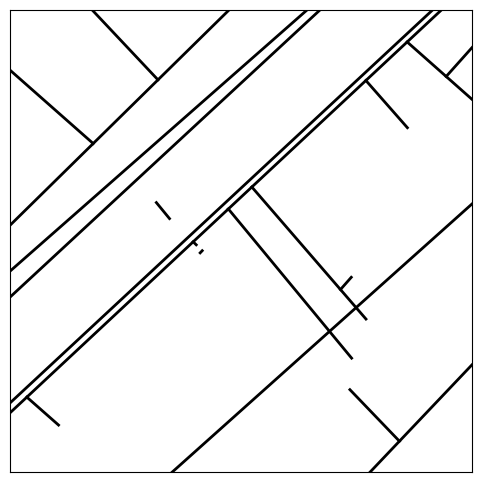

In [10]:
plt.figure(figsize=(6,6))
for f in final_fractures:
    x, y, θ, h = f['x'], f['y'], f['theta'], f['h']
    dx = h * math.cos(θ)
    dy = h * math.sin(θ)
    x1, y1 = x - dx, y - dy
    x2, y2 = x + dx, y + dy
    color = 'black' if f['active'] else 'black'
    plt.plot([x1, x2], [y1, y2], color=color, linewidth=2)

plt.xlim(0, L)
plt.ylim(0, L)
plt.gca().set_aspect('equal', 'box')
# plt.title(f"DFN at t = {T_total:.2f} (black=arrested, red=still active)")
plt.yticks([])
plt.xticks([])
plt.savefig('random-dfn.png', dpi = 300)
plt.show()


# combine the data

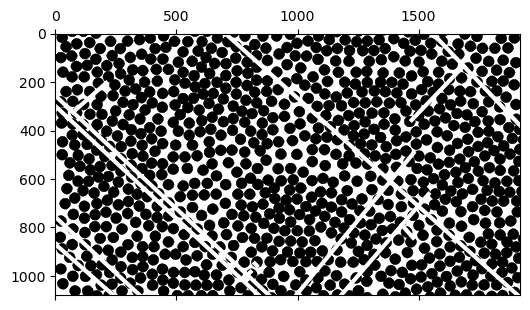

In [11]:

aperture = 3

# Create the figure and canvas
fig = plt.figure(figsize=(6, 6))
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)

# Plot sparse geom matrix
ax.spy(geom, markersize=0.1, color = 'k')

# Plot fractures
for f in final_fractures:
    x, y, θ, h = f['x'], f['y'], f['theta'], f['h']
    dx = h * math.cos(θ)
    dy = h * math.sin(θ)
    x1, y1 = x - dx, y - dy
    x2, y2 = x + dx, y + dy
    color = 'white' if f['active'] else 'white'
    ax.plot([x1, x2], [y1, y2], color=color, linewidth=aperture)


In [ ]:


# Use actual geom shape
H, W = geom.shape
matrix = np.zeros((H, W), dtype=np.uint8)

# 1 = geom, start by copying in geom pixels
geom_nonzero = geom.nonzero()
matrix[geom_nonzero] = 1

# Thickness in pixels (Adjust apertures) 
fracture_thickness = 10

def draw_disk(matrix, i, j, radius):
    """Draw 0s in a disk shape to represent the fracture line (overrides existing 1s)."""
    for di in range(-radius, radius + 1):
        for dj in range(-radius, radius + 1):
            if di**2 + dj**2 <= radius**2:
                ii = i + di
                jj = j + dj
                if 0 <= ii < matrix.shape[0] and 0 <= jj < matrix.shape[1]:
                    matrix[ii, jj] = 0  # override with 0

# Rasterize fractures as 0s
for f in final_fractures:
    x, y, θ, h = f['x'], f['y'], f['theta'], f['h']
    dx = h * math.cos(θ)
    dy = h * math.sin(θ)
    x1, y1 = x - dx, y - dy
    x2, y2 = x + dx, y + dy

    # Sample along the fracture
    N = int(2 * h * 10)
    for t in np.linspace(0, 1, N):
        xt = x1 + t * (x2 - x1)
        yt = y1 + t * (y2 - y1)

        i = int(round(yt))
        j = int(round(xt))

        draw_disk(matrix, i, j, radius=fracture_thickness)


In [ ]:

import matplotlib.pyplot as plt
fig,ax = plt.subplots( figsize = (10,8)) 
ax.spy(matrix)
plt.show() 

In [ ]:
savemat("fracture_geom_matrix.mat", {"combined": matrix})